In [1]:
import argparse
import time
import numpy as np
import scipy.sparse as sp
import torch
from torch import optim
import torch.autograd as autograd
from torch.autograd import Variable
from model import GCNModelAE, Regularizer
from optimizer import loss_function1
from utils import load_data, mask_test_edges, preprocess_graph, get_roc_score,load_data_with_labels
import matplotlib.pyplot as plt

# Hyper-parameter Setting
Here we present the same setting in our paper WARGA

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--seed', type=int, default=0, help='Random seed.')
parser.add_argument('--epochs', type=int, default=200, help='Number of epochs to train.')
parser.add_argument('--hidden1', type=int, default=32, help='Number of units in the first encoding layer.')
parser.add_argument('--hidden2', type=int, default=16, help='Number of units in the second embedding layer.')
parser.add_argument('--hidden3', type=int, default=16, help='Number of units in the first hidden layer of Regularizer.')
parser.add_argument('--hidden4', type=int, default=64, help='Number of units in the second hidden layer of Regularizer.')
parser.add_argument('--gp_lambda', type=float, default=10.0, help='lambda for gradient penalty.')
parser.add_argument('--lr', type=float, default=0.001, help='Initial learning rate for Generator.')
parser.add_argument('--reglr', type=float, default=0.001, help='Initial learning rate for Regularizer.')
parser.add_argument('--dropout', type=float, default=0., help='Dropout rate (1 - keep probability).')
parser.add_argument('--dataset-str', type=str, default='citeseer', help='type of dataset.')

args,unknown = parser.parse_known_args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)    

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Model

In [3]:
# Cited from Improved Training of Wasserstein GANs 
# https://github.com/igul222/improved_wgan_training
def compute_gradient_penalty(D, real_samples, fake_samples):
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0), 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(Tensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(outputs=d_interpolates,
                              inputs=interpolates,
                              grad_outputs=fake,
                              create_graph=True,
                              retain_graph=True,
                              only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 0.01) ** 2).mean()
    return gradient_penalty

def gae_for(args):
    print("Using {} dataset".format(args.dataset_str))
    adj, features,true_labels = load_data_with_labels(args.dataset_str)
    n_nodes, feat_dim = features.shape
    features = features.to(device)
    
    # Store original adjacency matrix (without diagonal entries) for later
    adj_orig = adj
    adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
    adj_orig.eliminate_zeros()
    
    # train-validation-test split
    adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
    adj = adj_train
    
    # Some preprocessing
    adj_norm = preprocess_graph(adj)
    adj_norm = adj_norm.to(device)
    
    adj_label = adj_train + sp.eye(adj_train.shape[0])
    adj_label = torch.FloatTensor(adj_label.toarray())
    adj_label = adj_label.to(device)

    pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    
    # Models
    model = GCNModelAE(feat_dim, args.hidden1, args.hidden2, args.dropout).to(device)
    regularizer = Regularizer(args.hidden3, args.hidden2, args.hidden4).to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    regularizer_optimizer = optim.Adam(regularizer.parameters(), lr=args.reglr)

    val_ap = []
    train_loss = []
    for epoch in range(args.epochs):
        t = time.time()
        model.train()
        regularizer.train()
        
        # Generate the embeddings
        predicted_labels_prob, emb = model(features, adj_norm)
        
        # Wasserstein Regularizer
        for i in range(1):
            f_z = regularizer(emb).to(device)
            r = torch.normal(0.0, 1.0, [n_nodes, args.hidden2]).to(device)
            f_r = regularizer(r)          
            
            # add the gradient penalty to objective function
            gradient_penalty = compute_gradient_penalty(regularizer, r, emb)
            
            reg_loss = - f_r.mean() + f_z.mean() + args.gp_lambda * gradient_penalty
            
            regularizer_optimizer.zero_grad()
            reg_loss.backward(retain_graph=True)
            regularizer_optimizer.step()
            

        # Update the Generator
        f_z = regularizer(emb)  
        generator_loss = -f_z.mean()       
        loss = loss_function1(preds=predicted_labels_prob, labels=adj_label,
                             norm=norm, pos_weight=torch.tensor(pos_weight))
        loss = loss + generator_loss
        optimizer.zero_grad()
        loss.backward()
        cur_loss = loss.item()
        optimizer.step()
        
        # Print Validation results every 10 epochs
        if epoch%40 == 0:
            hidden_emb = emb.cpu().data.numpy()
            roc_curr, ap_curr = get_roc_score(hidden_emb, adj_orig, val_edges, val_edges_false)
            print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(cur_loss))
            print("val_ap=", "{:.5f}".format(ap_curr))  
            print("time=", "{:.5f}".format(time.time() - t))
            val_ap.append(ap_curr)
            train_loss.append(cur_loss)
        
    print("Optimization Finished!")
    
    # Plot the learning curve
    fig = plt.figure(figsize=(30,10))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    ax1.plot(train_loss, label='Training loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend(frameon=False)

    ax2.plot(val_ap, label='Validation Average Precision Score',color='Red')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('AP')
    ax2.legend(frameon=False)

    plt.show()
    
    # Testing results
    hidden_emb = emb.cpu().data.numpy()
    roc_score, ap_score = get_roc_score(hidden_emb, adj_orig, test_edges, test_edges_false)
    print("The Last Epoch's Results are:")
    print('Test ROC score: ' + str(roc_score))
    print('Test AP score: ' + str(ap_score))
    
    return roc_score, ap_score

# Run

Seed 0
Using citeseer dataset
Epoch: 0001 train_loss= 0.82644
val_ap= 0.71276
time= 0.75397
Epoch: 0041 train_loss= 0.55057
val_ap= 0.92169
time= 0.07879
Epoch: 0081 train_loss= 0.55355
val_ap= 0.94972
time= 0.08876
Epoch: 0121 train_loss= 0.59125
val_ap= 0.95796
time= 0.07979
Epoch: 0161 train_loss= 0.62423
val_ap= 0.96029
time= 0.07478
Optimization Finished!


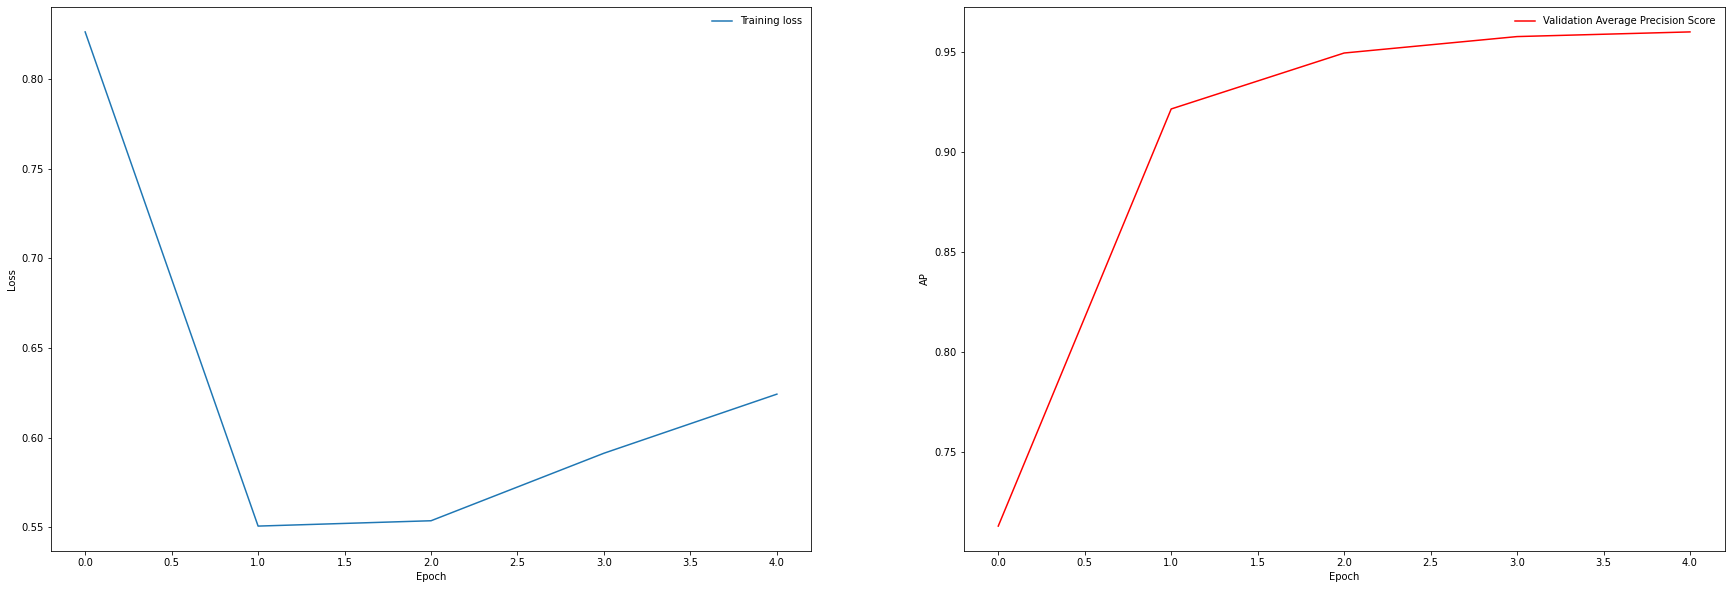

The Last Epoch's Results are:
Test ROC score: 0.9352880086946022
Test AP score: 0.9401117770256154
Seed 1
Using citeseer dataset
Epoch: 0001 train_loss= 0.83057
val_ap= 0.64862
time= 0.09774
Epoch: 0041 train_loss= 0.57802
val_ap= 0.91576
time= 0.09175
Epoch: 0081 train_loss= 0.55847
val_ap= 0.93621
time= 0.09475
Epoch: 0121 train_loss= 0.58865
val_ap= 0.93624
time= 0.07580
Epoch: 0161 train_loss= 0.62179
val_ap= 0.93659
time= 0.08876
Optimization Finished!


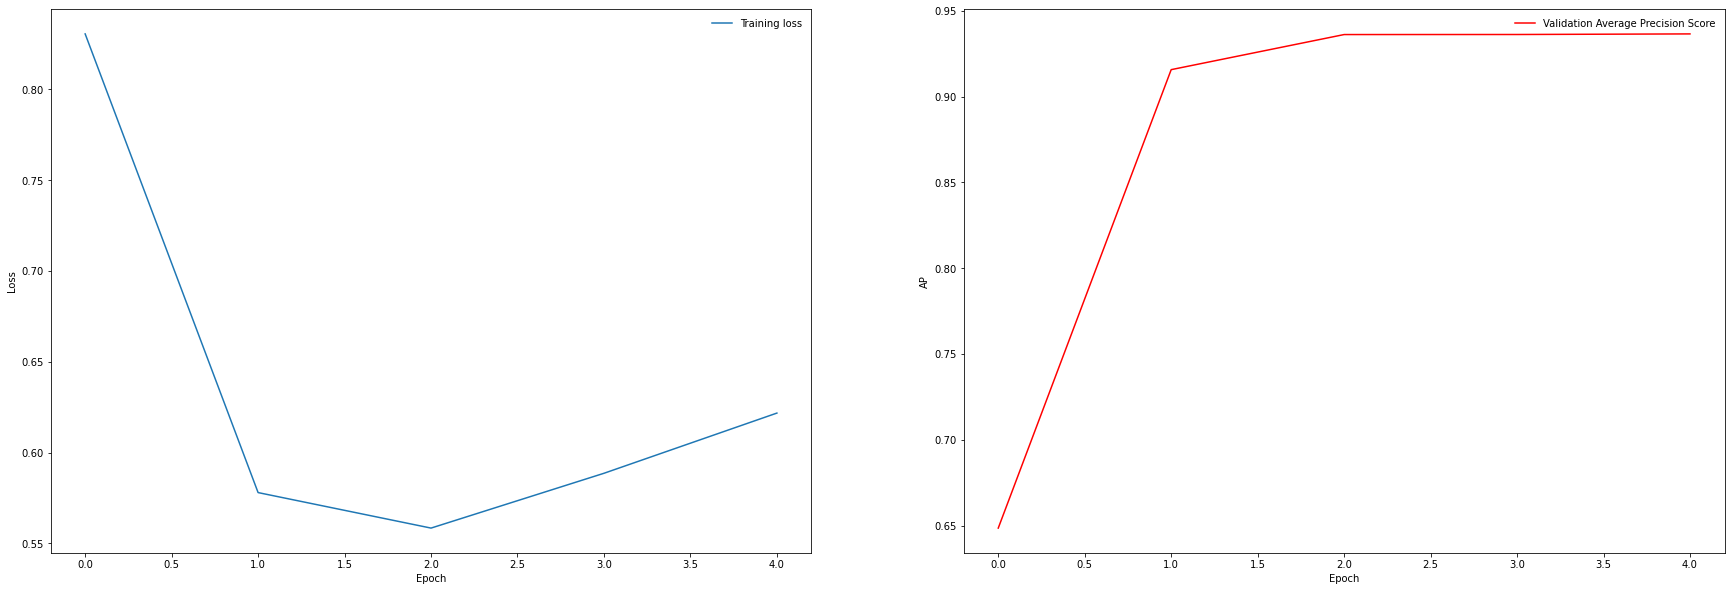

The Last Epoch's Results are:
Test ROC score: 0.9268687356599444
Test AP score: 0.9348594186958434
Seed 2
Using citeseer dataset
Epoch: 0001 train_loss= 0.82535
val_ap= 0.70440
time= 0.08776
Epoch: 0041 train_loss= 0.53254
val_ap= 0.88419
time= 0.07280
Epoch: 0081 train_loss= 0.51273
val_ap= 0.92887
time= 0.06483
Epoch: 0121 train_loss= 0.53514
val_ap= 0.93879
time= 0.07480
Epoch: 0161 train_loss= 0.56292
val_ap= 0.93982
time= 0.07780
Optimization Finished!


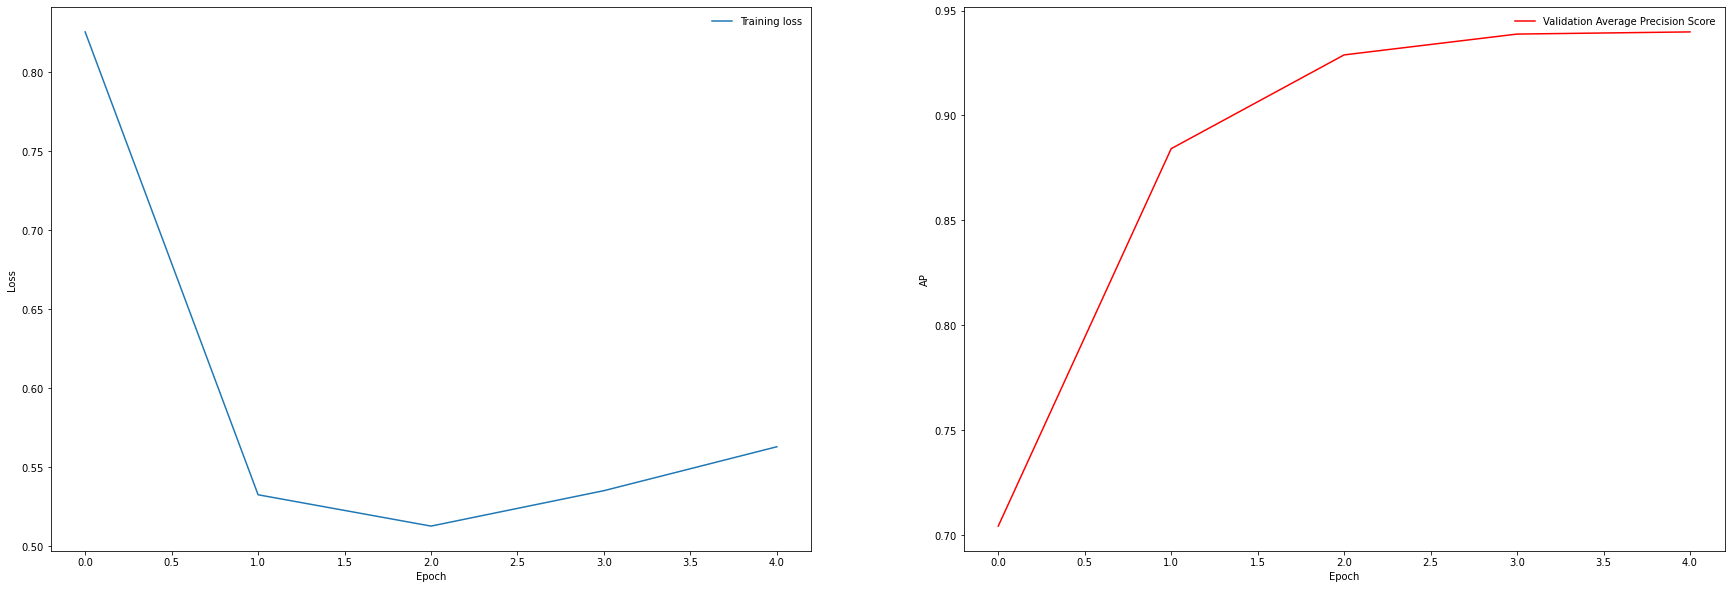

The Last Epoch's Results are:
Test ROC score: 0.9220722135007849
Test AP score: 0.9287143810708703
Seed 3
Using citeseer dataset
Epoch: 0001 train_loss= 0.83006
val_ap= 0.67599
time= 0.08376
Epoch: 0041 train_loss= 0.53054
val_ap= 0.90891
time= 0.07679
Epoch: 0081 train_loss= 0.52432
val_ap= 0.93250
time= 0.06782
Epoch: 0121 train_loss= 0.55659
val_ap= 0.93964
time= 0.06981
Epoch: 0161 train_loss= 0.59473
val_ap= 0.94458
time= 0.07680
Optimization Finished!


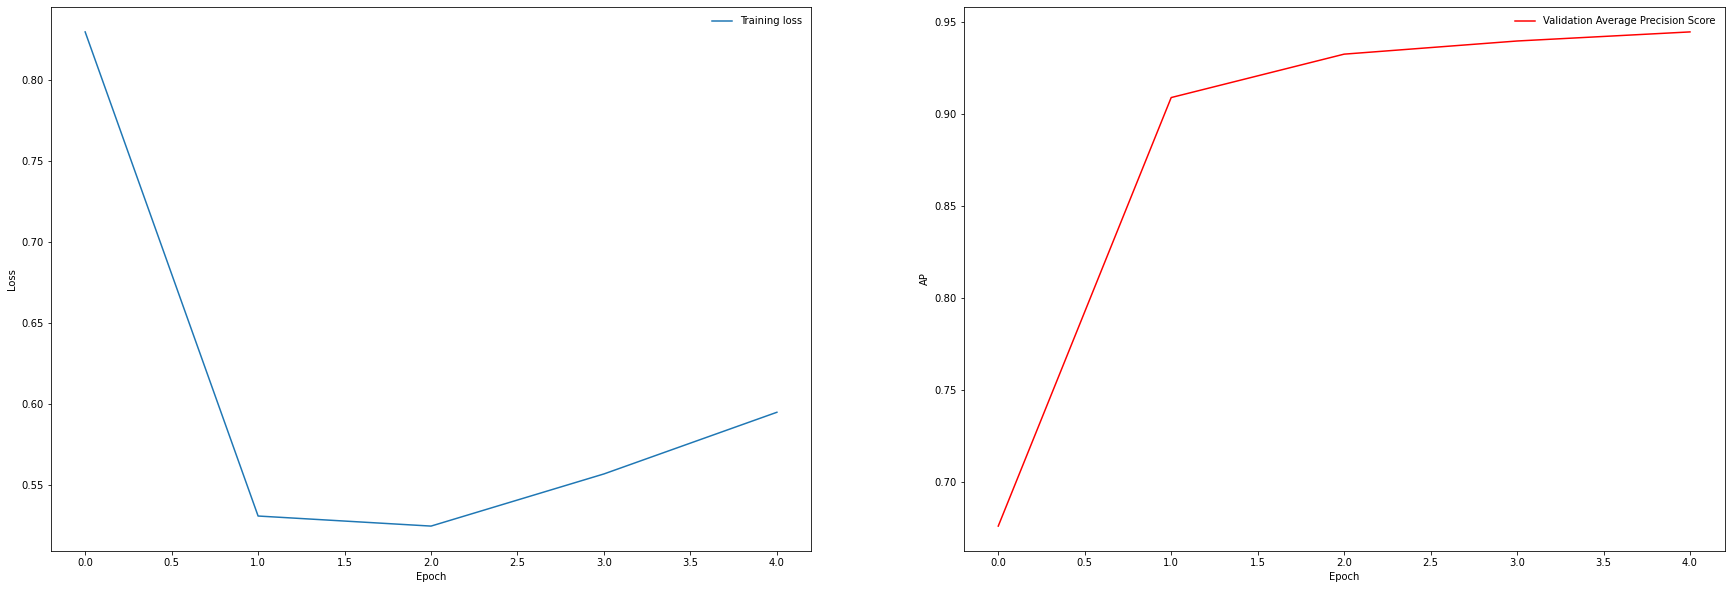

The Last Epoch's Results are:
Test ROC score: 0.9344282091534839
Test AP score: 0.9382261714899925
Seed 4
Using citeseer dataset
Epoch: 0001 train_loss= 0.82507
val_ap= 0.61902
time= 0.06582
Epoch: 0041 train_loss= 0.52192
val_ap= 0.89128
time= 0.06483
Epoch: 0081 train_loss= 0.52177
val_ap= 0.91888
time= 0.06582
Epoch: 0121 train_loss= 0.55338
val_ap= 0.92567
time= 0.07181
Epoch: 0161 train_loss= 0.58736
val_ap= 0.93029
time= 0.06982
Optimization Finished!


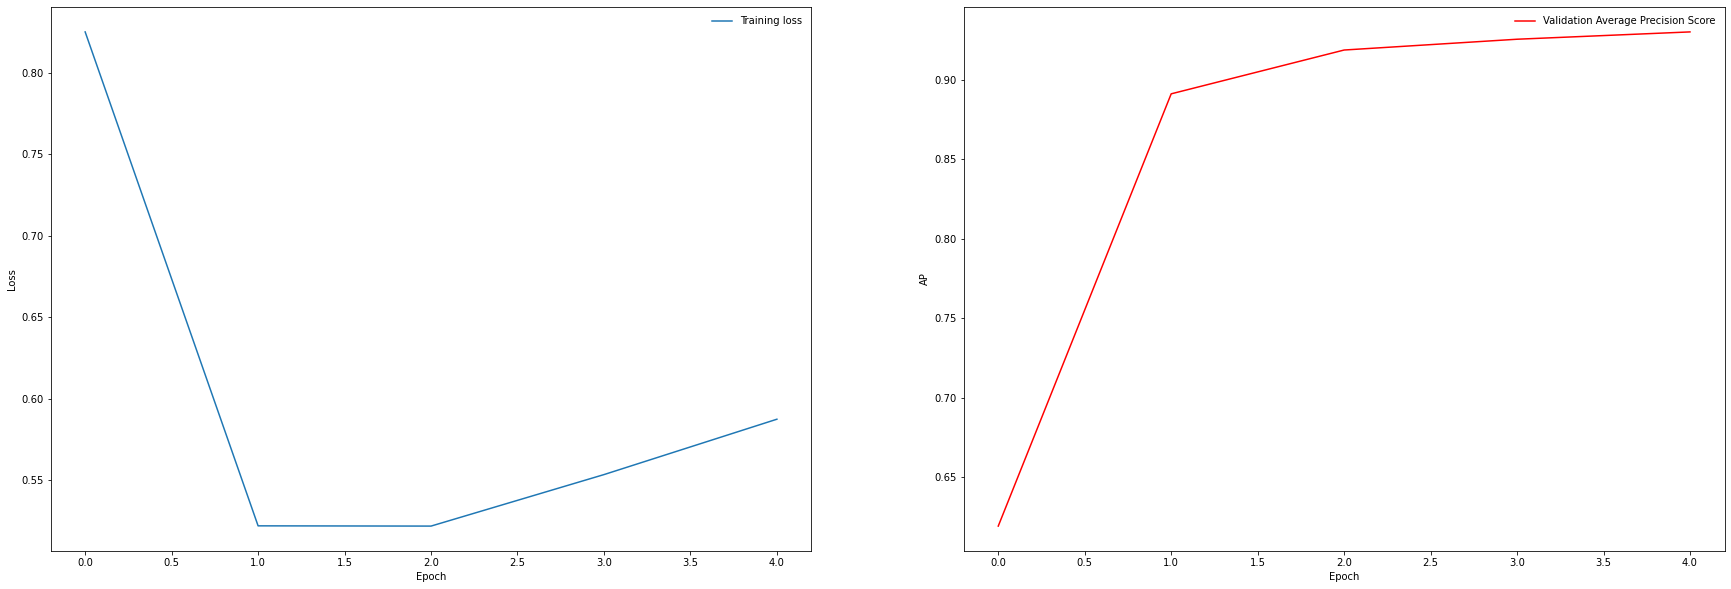

The Last Epoch's Results are:
Test ROC score: 0.9305977538944571
Test AP score: 0.938705595653273
Seed 5
Using citeseer dataset
Epoch: 0001 train_loss= 0.82848
val_ap= 0.65902
time= 0.07280
Epoch: 0041 train_loss= 0.41866
val_ap= 0.90876
time= 0.07480
Epoch: 0081 train_loss= 0.43379
val_ap= 0.93638
time= 0.07380
Epoch: 0121 train_loss= 0.47392
val_ap= 0.94655
time= 0.06882
Epoch: 0161 train_loss= 0.52299
val_ap= 0.94918
time= 0.06981
Optimization Finished!


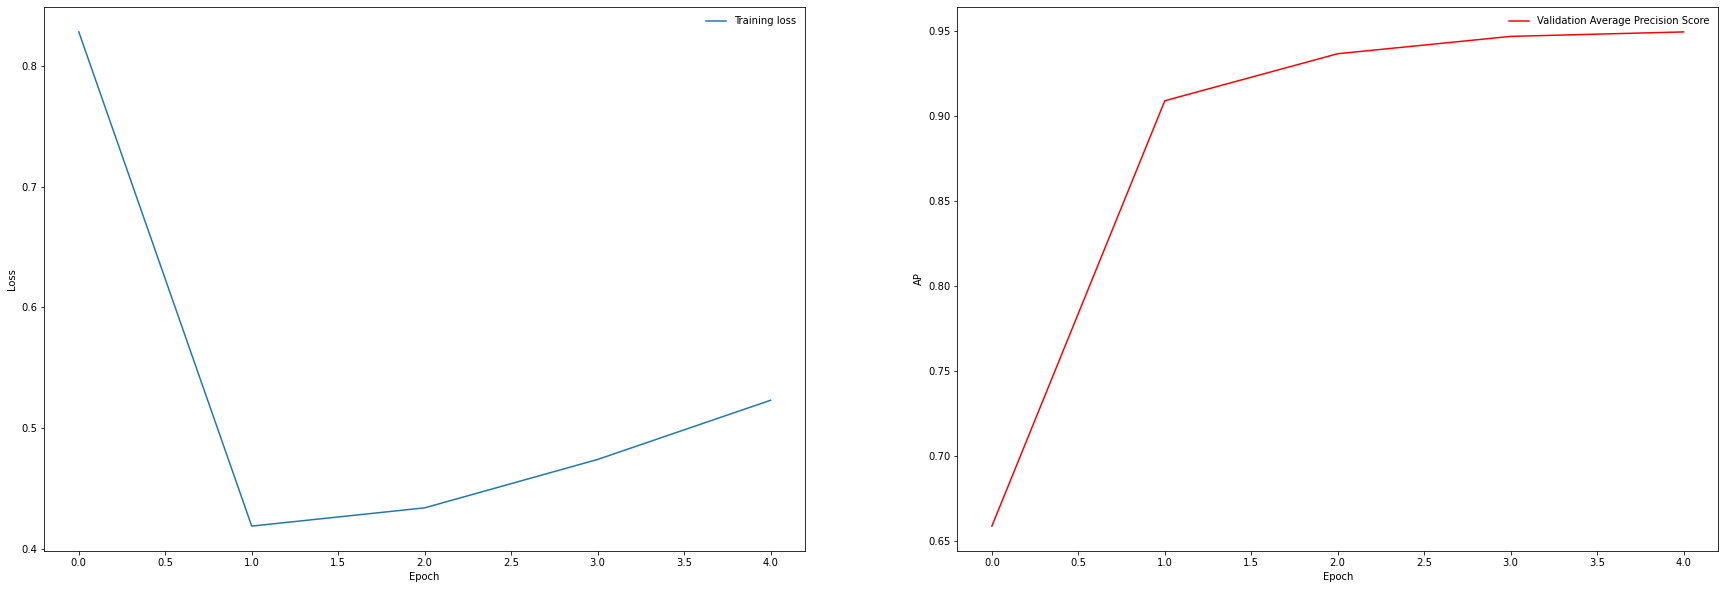

The Last Epoch's Results are:
Test ROC score: 0.9312063760415409
Test AP score: 0.9386395666736818
Seed 6
Using citeseer dataset
Epoch: 0001 train_loss= 0.83676
val_ap= 0.67123
time= 0.06682
Epoch: 0041 train_loss= 0.62648
val_ap= 0.89425
time= 0.06283
Epoch: 0081 train_loss= 0.63178
val_ap= 0.91724
time= 0.07380
Epoch: 0121 train_loss= 0.66786
val_ap= 0.92534
time= 0.07082
Epoch: 0161 train_loss= 0.70811
val_ap= 0.92924
time= 0.06383
Optimization Finished!


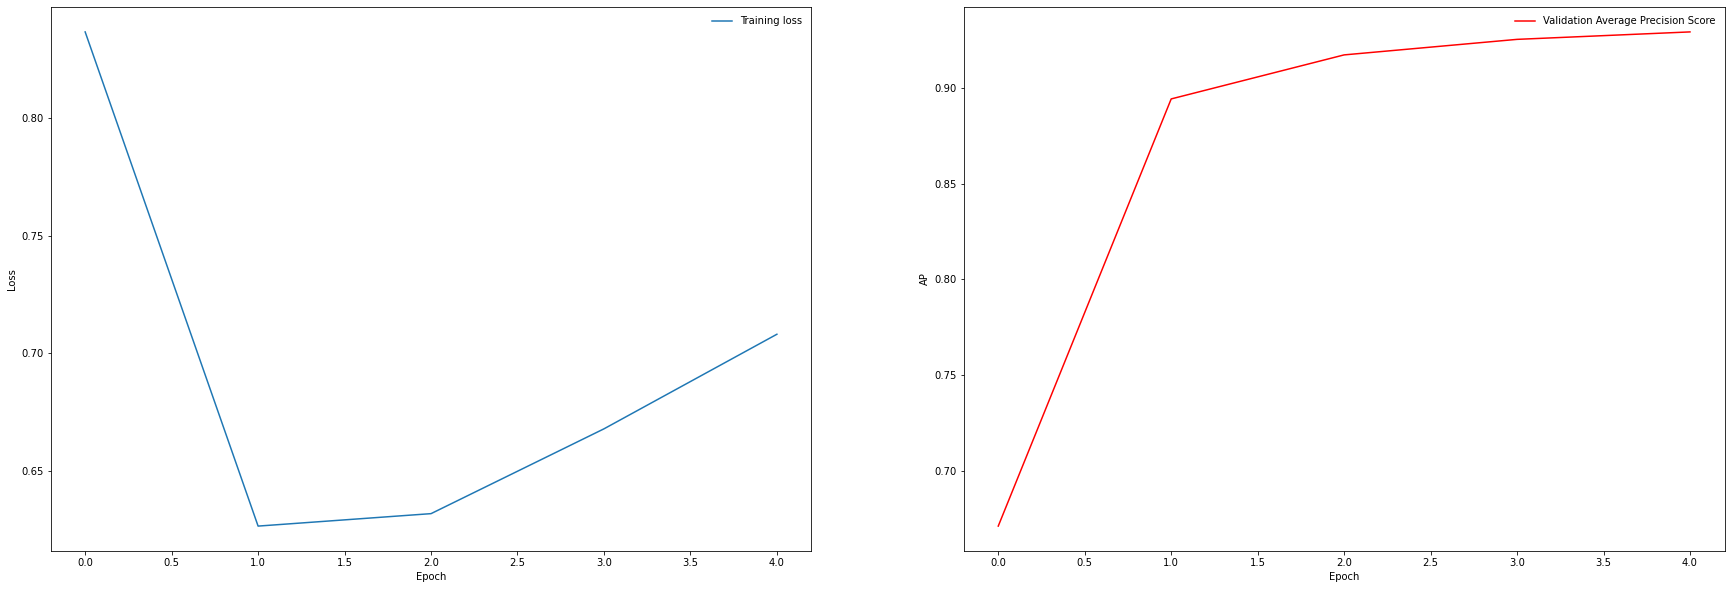

The Last Epoch's Results are:
Test ROC score: 0.9299504890713682
Test AP score: 0.9387295922430481
Seed 7
Using citeseer dataset
Epoch: 0001 train_loss= 0.82402
val_ap= 0.63835
time= 0.07280
Epoch: 0041 train_loss= 0.33719
val_ap= 0.91357
time= 0.06682
Epoch: 0081 train_loss= 0.35536
val_ap= 0.92831
time= 0.07480
Epoch: 0121 train_loss= 0.38807
val_ap= 0.92735
time= 0.06682
Epoch: 0161 train_loss= 0.42862
val_ap= 0.92906
time= 0.06981
Optimization Finished!


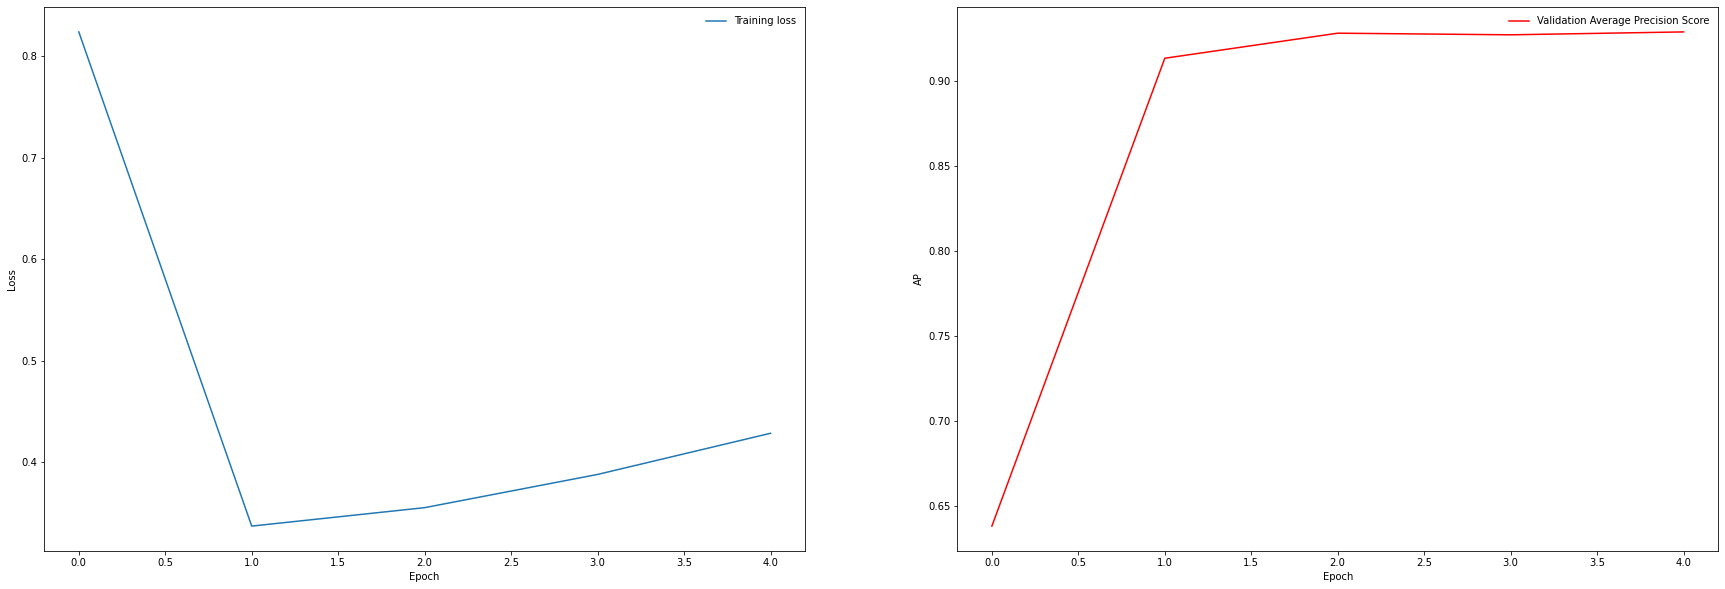

The Last Epoch's Results are:
Test ROC score: 0.928327496679145
Test AP score: 0.9361416147462198
Seed 8
Using citeseer dataset
Epoch: 0001 train_loss= 0.82680
val_ap= 0.63187
time= 0.08776
Epoch: 0041 train_loss= 0.50653
val_ap= 0.89234
time= 0.07181
Epoch: 0081 train_loss= 0.50823
val_ap= 0.92280
time= 0.07480
Epoch: 0121 train_loss= 0.54267
val_ap= 0.93609
time= 0.06583
Epoch: 0161 train_loss= 0.57700
val_ap= 0.94119
time= 0.06383
Optimization Finished!


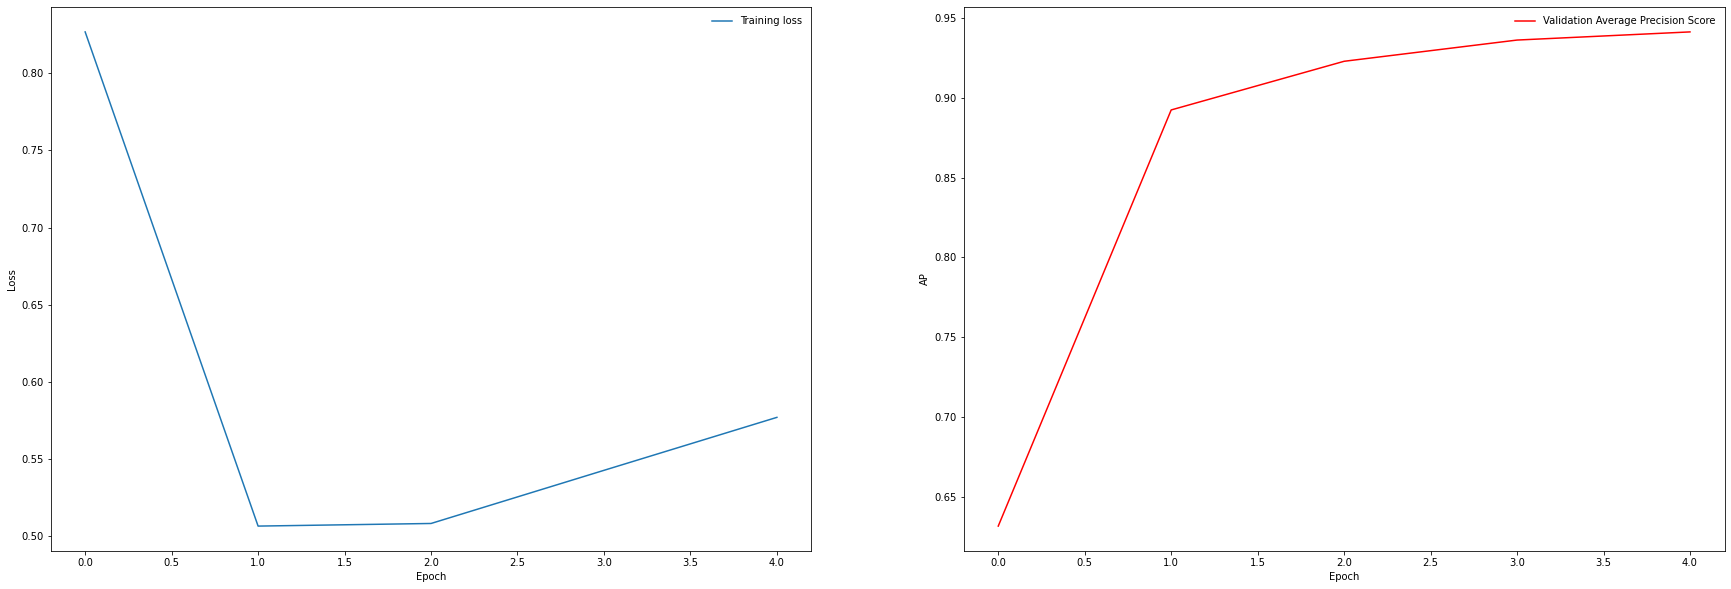

The Last Epoch's Results are:
Test ROC score: 0.9309165559715011
Test AP score: 0.9351339651676024
Seed 9
Using citeseer dataset
Epoch: 0001 train_loss= 0.82634
val_ap= 0.71109
time= 0.08278
Epoch: 0041 train_loss= 0.52902
val_ap= 0.91290
time= 0.07480
Epoch: 0081 train_loss= 0.54449
val_ap= 0.93620
time= 0.06483
Epoch: 0121 train_loss= 0.58353
val_ap= 0.93733
time= 0.06382
Epoch: 0161 train_loss= 0.63293
val_ap= 0.93872
time= 0.06582
Optimization Finished!


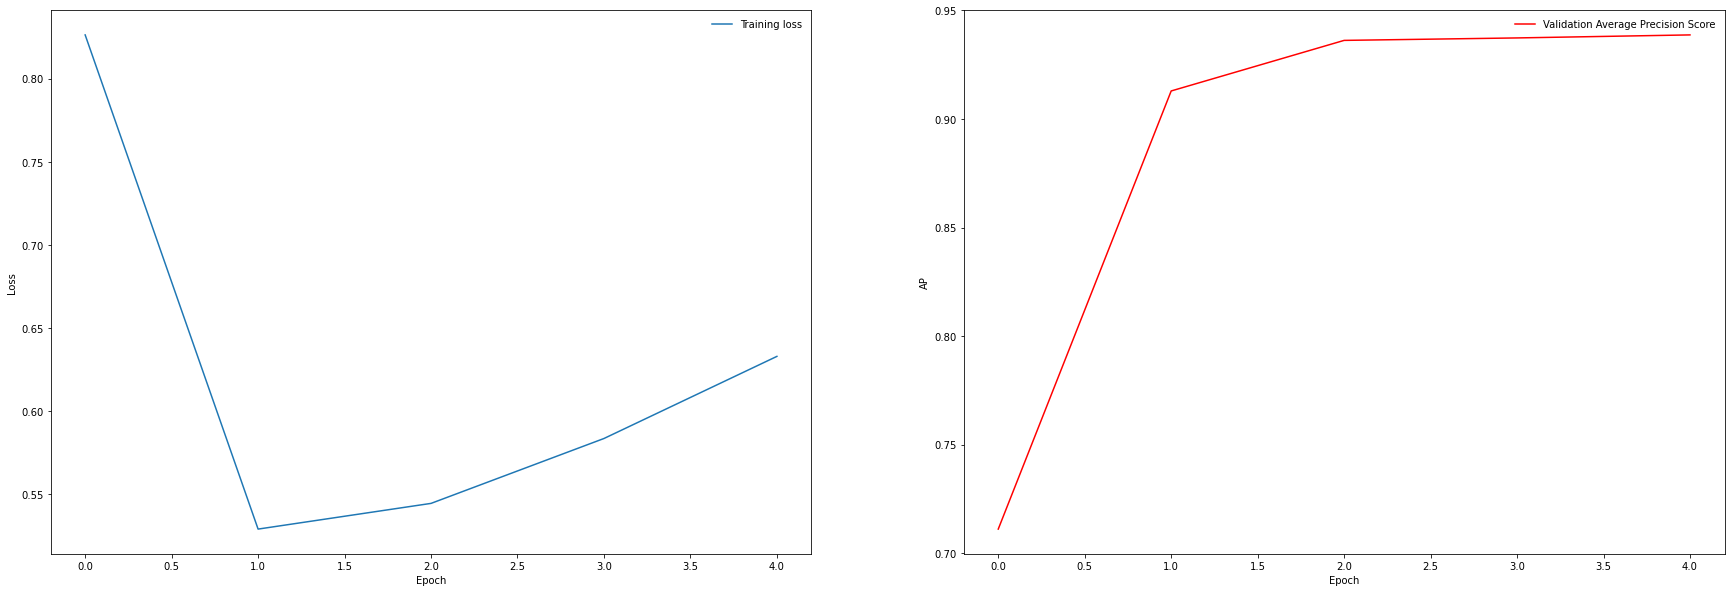

The Last Epoch's Results are:
Test ROC score: 0.9222074628668036
Test AP score: 0.9274807553397696
[0.9352880086946022, 0.9268687356599444, 0.9220722135007849, 0.9344282091534839, 0.9305977538944571, 0.9312063760415409, 0.9299504890713682, 0.928327496679145, 0.9309165559715011, 0.9222074628668036]
mean test AUC is 0.9291863301533632  std  0.0042400729073422015
[0.9401117770256154, 0.9348594186958434, 0.9287143810708703, 0.9382261714899925, 0.938705595653273, 0.9386395666736818, 0.9387295922430481, 0.9361416147462198, 0.9351339651676024, 0.9274807553397696]
mean test AP is  0.9356742838105918  std  0.004126362112902336


In [4]:
once = False

if __name__ == '__main__':
    if once == True:
        gae_for(args)
    
    else:
        test_roc = []
        test_ap = []
        
        # Run with 10 different random seeds
        for seed in range(10):
            print('Seed',seed)
            args.seed = seed
            torch.manual_seed(args.seed)
            roc_score, ap_score = gae_for(args)
            test_roc.append(roc_score)
            test_ap.append(ap_score)
        
        # show results by mean and std
        print(test_roc)
        print('mean test AUC is',np.mean(test_roc),' std ', np.std(test_roc))
        print(test_ap)
        print('mean test AP is ',np.mean(test_ap), ' std ', np.std(test_ap))